# [KerasCV] YOLOv8 Semantic Segmentation

**Author:** [Usha Rengaraju](https://www.linkedin.com/in/usha-rengaraju-b570b7a2/)<br>
**Date created:** 2023/07/10<br>
**Last modified:** 2023/07/10<br>
**Description:** YOLOV8 Semantic Segmentation using KerasCV

## Overview

Semantic Segmentation is the process of classifying the pixels in an image to different semantic classes like sky, person, car etc. Semantic Segmentation is a very useful task in autonomous driving.

In this guide we show you how to use the `yolov8detector` backbone of KerasCV to perform the semantic segmentation task.

## Imports & setup

This tutorial requires you to have KerasCV installed:

```shell
pip install keras-cv
```

We begin by importing all required packages:

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

## Data loading

This guide uses the
[Human Parsing dataset](https://paperswithcode.com/task/human-parsing)
for demonstration purposes.

To get started, we first download and unzip the dataset:

In [ ]:
!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:44<00:00, 65.9MB/s]


Next we resize the images to `512x512` and prepare the data generator for model training

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


## Model Building

Next we move on to the model building stage. We create a Unet model with skip connections. For the encoder part we use the `Yolov8detector` model and Conv2dTranspose based structure for the decoder part.

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone(
    input_shape = (512,512,3),
    stackwise_channels=[ 128, 256],
    stackwise_depth=[ 1, 1],
    include_rescaling=False,
)

inp = backbone.input
x = backbone.output
x= Activation("relu")(x)
x = Conv2DTranspose(128,2,2)(x)
conc = backbone.get_layer('stack1_c2f_output_conv').output
x = Concatenate()([x, conc])
x= tf.concat([conc,x],3)
x = Conv2DTranspose(128,3,padding='same')(x)
conc = backbone.get_layer('stack1_c2f_pre_conv').output
x= tf.concat([x,conc],3)
x = Conv2DTranspose(64,2,2)(x)
conc = backbone.get_layer('stem_1_conv').output
x= tf.concat([x,conc],3)

x = UpSampling2D(2, interpolation='bicubic')(x)
x = Conv2D(NUM_CLASSES,1,padding='same')(x)
model = keras.Model(inputs=inp,outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 yolov8_backbone_20 (YOLOV8Back  (None, 64, 64, 256)  1115584    ['input_42[0][0]']               
 bone)                                                                                            
                                                                                                  
 activation_20 (Activation)     (None, 64, 64, 256)  0           ['yolov8_backbone_20[0][0]']     
                                                                                              

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=10e-5),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset,verbose=1, epochs=25)

Epoch 1/25
250/250 [==============================] - 60s 156ms/step - loss: 2.7828 - accuracy: 0.0515 - val_loss: 2.6030 - val_accuracy: 0.0816
Epoch 2/25
250/250 [==============================] - 39s 156ms/step - loss: 2.5622 - accuracy: 0.3259 - val_loss: 2.6120 - val_accuracy: 0.5036
Epoch 3/25
250/250 [==============================] - 39s 154ms/step - loss: 2.3874 - accuracy: 0.5855 - val_loss: 2.6006 - val_accuracy: 0.5647
Epoch 4/25
250/250 [==============================] - 39s 154ms/step - loss: 2.2507 - accuracy: 0.6149 - val_loss: 2.3421 - val_accuracy: 0.5943
Epoch 5/25
250/250 [==============================] - 39s 156ms/step - loss: 2.1194 - accuracy: 0.6287 - val_loss: 2.4306 - val_accuracy: 0.5740
Epoch 6/25
250/250 [==============================] - 38s 152ms/step - loss: 1.9952 - accuracy: 0.6408 - val_loss: 2.2158 - val_accuracy: 0.5974
Epoch 7/25
250/250 [==============================] - 39s 157ms/step - loss: 1.8822 - accuracy: 0.6490 - val_loss: 2.1149 - val_ac

## Training Statistics Visualisation

Now we plot the loss and accuracy variation of the model while training over the epochs

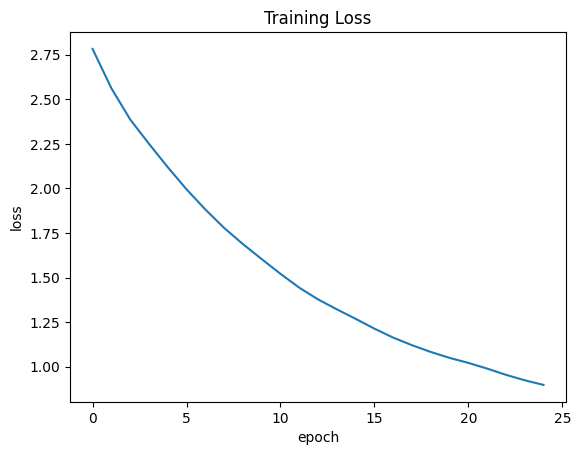

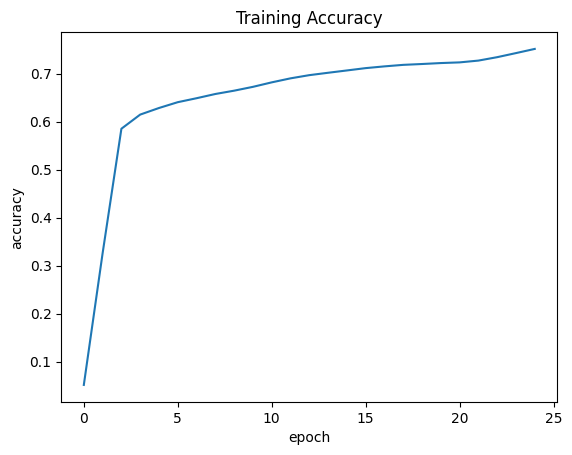

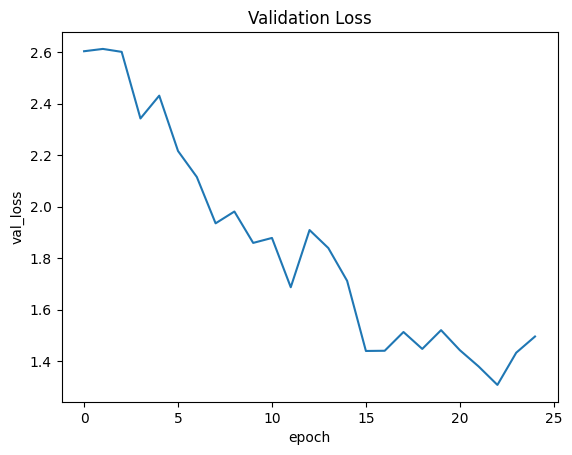

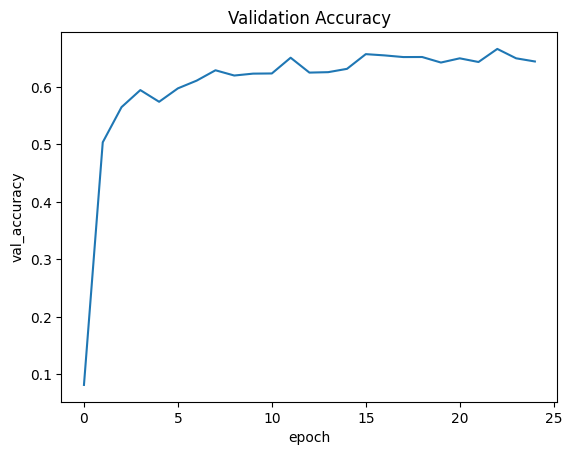

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

## Prediction Visualisation

Now we use the trained model to make some predictions over dataset batch and visualise them with overlay to see how well the model is trained.

In [ ]:
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 0s 41ms/step


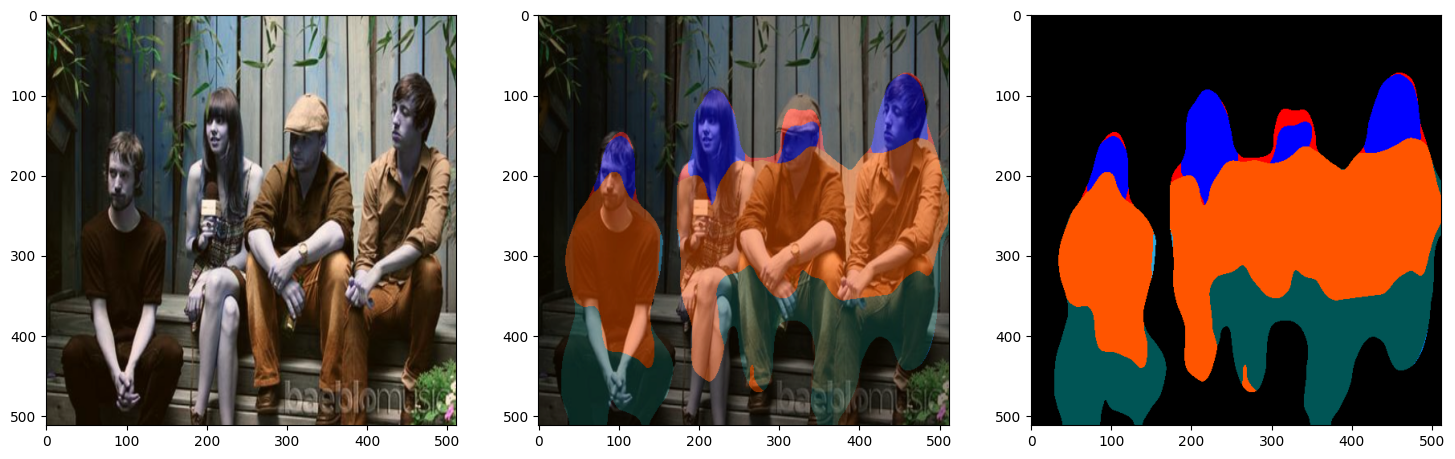

1/1 [==============================] - 0s 45ms/step


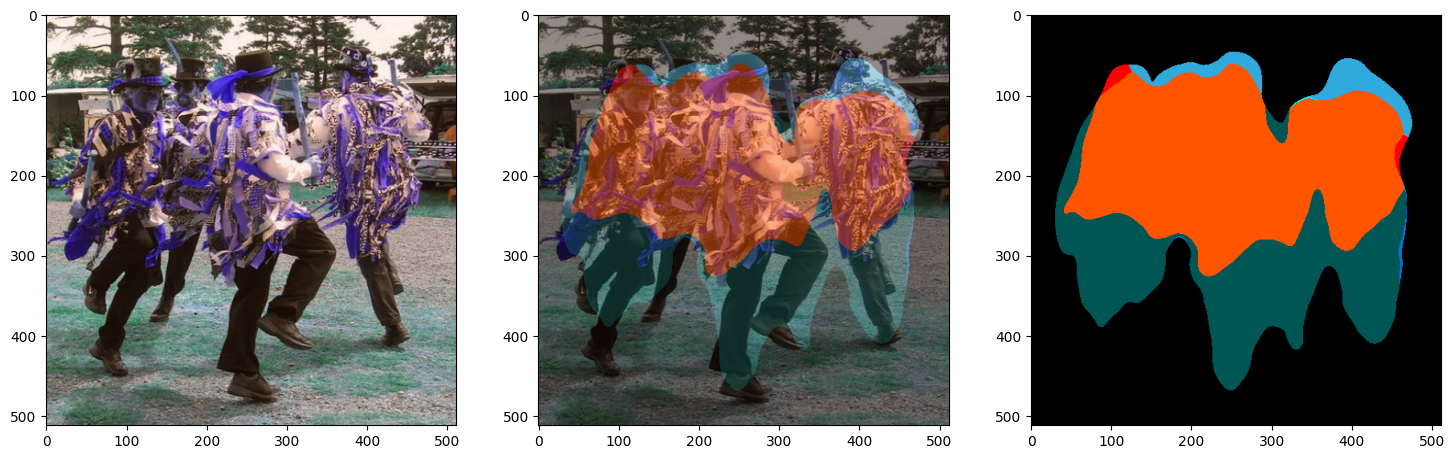

1/1 [==============================] - 0s 38ms/step


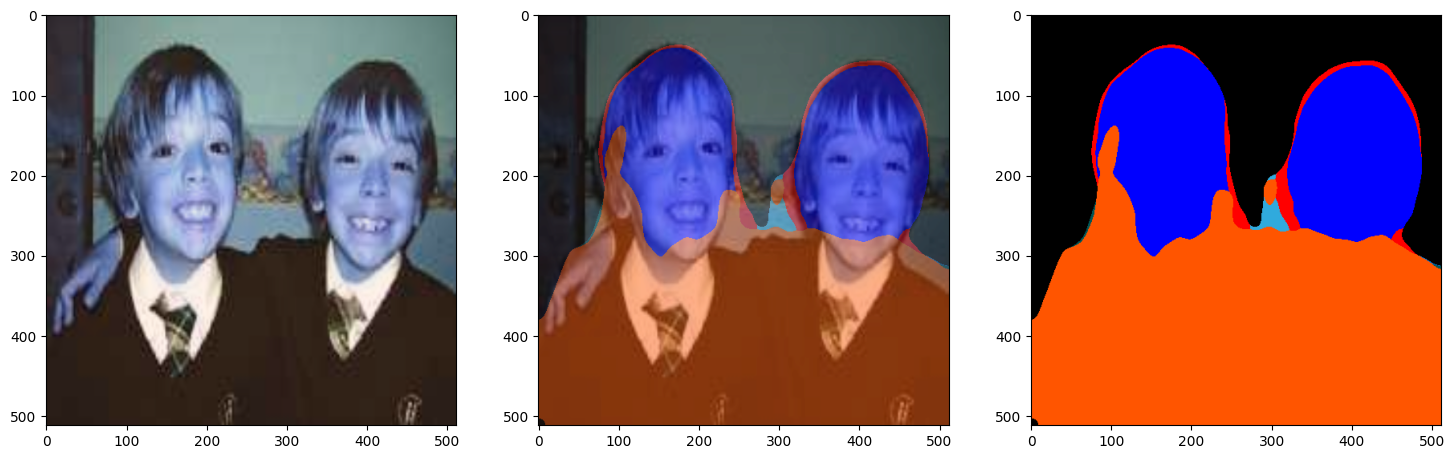

1/1 [==============================] - 0s 37ms/step


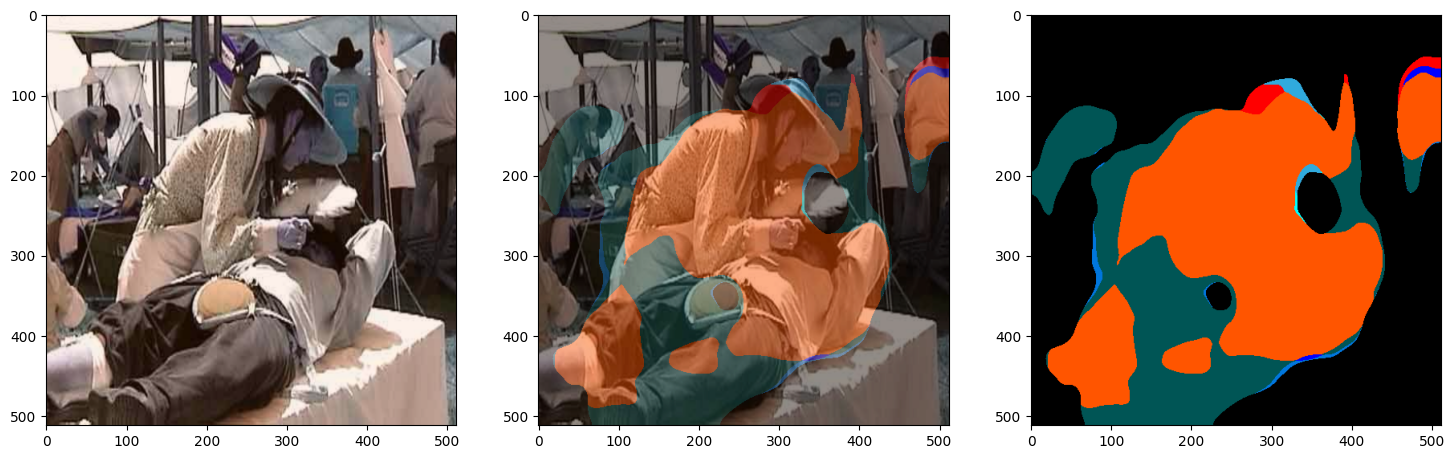

In [ ]:
plot_predictions(train_images[1:5], colormap, model=model)